# ML Model 02: ElasticNet Regression (L1+L2)\n
\n
This notebook mirrors `notebooks/ML_Linear_Models_01_OLS_Ridge_Lasso.ipynb`, but trains an **ElasticNet** model.\n
\n
- Dataset: `dataset/features/all_features.parquet`\n
- Target: `ret_1d` shifted forward by 1 day per asset\n
- Split: asset-based (75 train / 15 val / remaining test)\n
- Tuning: time-aware folds by unique dates within training assets\n

In [1]:
import os
from dataclasses import dataclass

import numpy as np
import pandas as pd
from IPython.display import display
from scipy.stats import spearmanr

from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [2]:
SEED = 42
rng = np.random.default_rng(SEED)

FEATURES_PARQUET_PATH = '../dataset/features/all_features.parquet'
TARGET_COL = 'ret_1d'
TARGET_FWD_COL = 'y_ret_1d_fwd'

N_TRAIN_ASSETS = 75
N_VAL_ASSETS = 15

N_DATE_FOLDS = 5

ALPHA_GRID = [1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0]
L1_RATIO_GRID = [0.1, 0.3, 0.5, 0.7, 0.9]

OUTPUT_DIR = '../dataset/model_outputs/linear_models_02_elasticnet'
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [3]:
df = pd.read_parquet(FEATURES_PARQUET_PATH)
# Support both formats: Date as index (older) or Date as a column (CSV->Parquet conversion).
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
df = df.sort_index()
df = df.copy()
df[TARGET_FWD_COL] = df.groupby('Asset_ID', sort=False)[TARGET_COL].shift(-1)
df = df.dropna(subset=[TARGET_FWD_COL])

assets = sorted(df['Asset_ID'].unique())
train_assets = assets[:N_TRAIN_ASSETS]
val_assets = assets[N_TRAIN_ASSETS:N_TRAIN_ASSETS + N_VAL_ASSETS]
test_assets = assets[N_TRAIN_ASSETS + N_VAL_ASSETS:]

df_train = df[df['Asset_ID'].isin(train_assets)].copy()
df_val = df[df['Asset_ID'].isin(val_assets)].copy()
df_test = df[df['Asset_ID'].isin(test_assets)].copy()

exclude_cols = {'Asset_ID', TARGET_FWD_COL}
feature_cols = [c for c in df.columns if c not in exclude_cols and pd.api.types.is_numeric_dtype(df[c])]

def to_xy(d: pd.DataFrame):
    X = d.loc[:, feature_cols].replace([np.inf, -np.inf], np.nan)
    y = d.loc[:, TARGET_FWD_COL]
    return X, y

X_train, y_train = to_xy(df_train)
X_val, y_val = to_xy(df_val)
X_test, y_test = to_xy(df_test)

print('assets train/val/test:', len(train_assets), len(val_assets), len(test_assets))
print('rows train/val/test:', X_train.shape[0], X_val.shape[0], X_test.shape[0])
print('n_features:', len(feature_cols))


assets train/val/test: 75 15 10
rows train/val/test: 188250 37650 25100
n_features: 121


In [4]:
@dataclass(frozen=True)
class RegressionMetrics:
    rmse: float
    mae: float
    r2: float
    spearman_ic: float


def compute_metrics(y_true: pd.Series, y_pred: np.ndarray) -> RegressionMetrics:
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae = float(mean_absolute_error(y_true, y_pred))
    r2 = float(r2_score(y_true, y_pred))
    ic = float(spearmanr(y_true.to_numpy(), y_pred, nan_policy='omit').correlation)
    return RegressionMetrics(rmse=rmse, mae=mae, r2=r2, spearman_ic=ic)


def date_folds(index: pd.DatetimeIndex, n_splits: int) -> list[tuple[np.ndarray, np.ndarray]]:
    """Create expanding-window folds over unique dates.

    We split the unique dates into (n_splits + 1) consecutive blocks.
    Fold i trains on blocks[0:i] and tests on block[i].
"""
    unique_dates = pd.Index(index.unique()).sort_values()
    if len(unique_dates) < 3:
        return []

    n_splits = int(min(n_splits, len(unique_dates) - 1))
    if n_splits < 1:
        return []

    blocks = np.array_split(unique_dates.to_numpy(), n_splits + 1)

    folds: list[tuple[np.ndarray, np.ndarray]] = []
    for i in range(1, len(blocks)):
        train_dates = pd.Index(np.concatenate(blocks[:i]))
        test_dates = pd.Index(blocks[i])
        tr = np.flatnonzero(index.isin(train_dates))
        te = np.flatnonzero(index.isin(test_dates))
        if len(tr) and len(te):
            folds.append((tr, te))
    return folds

train_folds = date_folds(df_train.index, n_splits=N_DATE_FOLDS)
print('n_date_folds:', len(train_folds))


n_date_folds: 5


In [5]:
def tune_elasticnet(alpha_grid: list[float], l1_grid: list[float]) -> tuple[tuple[float, float], pd.DataFrame]:
    rows = []
    for a in alpha_grid:
        for l1 in l1_grid:
            pipe = Pipeline(
                steps=[
                    ('imputer', SimpleImputer(strategy='median')),
                    ('scaler', StandardScaler()),
                    ('model', ElasticNet(alpha=a, l1_ratio=l1, random_state=SEED, max_iter=20_000)),
                ]
            )
            rmses = []
            for tr_idx, te_idx in train_folds:
                X_tr = X_train.iloc[tr_idx]
                y_tr = y_train.iloc[tr_idx]
                X_te = X_train.iloc[te_idx]
                y_te = y_train.iloc[te_idx]
                pipe.fit(X_tr, y_tr)
                pred = pipe.predict(X_te)
                rmses.append(float(np.sqrt(mean_squared_error(y_te, pred))))
            rows.append({'alpha': a, 'l1_ratio': l1, 'cv_rmse_mean': float(np.mean(rmses)), 'cv_rmse_std': float(np.std(rmses))})
    res = pd.DataFrame(rows).sort_values('cv_rmse_mean', ascending=True).reset_index(drop=True)
    best = (float(res.iloc[0]['alpha']), float(res.iloc[0]['l1_ratio']))
    return best, res

(best_alpha, best_l1), cv = tune_elasticnet(ALPHA_GRID, L1_RATIO_GRID)
display(cv.head(20))
print('best:', {'alpha': best_alpha, 'l1_ratio': best_l1})
cv.to_csv(os.path.join(OUTPUT_DIR, 'elasticnet_cv.csv'), index=False)

enet = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', ElasticNet(alpha=best_alpha, l1_ratio=best_l1, random_state=SEED, max_iter=20_000)),
    ]
)

enet.fit(X_train, y_train)

print('train:', compute_metrics(y_train, enet.predict(X_train)))
print('val  :', compute_metrics(y_val, enet.predict(X_val)))
print('test :', compute_metrics(y_test, enet.predict(X_test)))


,alpha,l1_ratio,cv_rmse_mean,cv_rmse_std
0,0.01,0.5,0.019516,0.002945
1,0.01,0.7,0.019516,0.002945
2,0.01,0.9,0.019516,0.002945
3,0.10,0.1,0.019516,0.002945
4,0.01,0.3,0.019516,0.002945
5,10.00,0.3,0.019516,0.002945
6,10.00,0.1,0.019516,0.002945
7,1.00,0.9,0.019516,0.002945
8,1.00,0.7,0.019516,0.002945
9,1.00,0.5,0.019516,0.002945


best: {'alpha': 0.01, 'l1_ratio': 0.5}
train: RegressionMetrics(rmse=0.018946526000414916, mae=0.012316601143005666, r2=0.0, spearman_ic=nan)
val  : RegressionMetrics(rmse=0.018101186960266604, mae=0.012035154499652341, r2=-3.72126660275196e-05, spearman_ic=nan)
test : RegressionMetrics(rmse=0.019662545780156013, mae=0.012961715128710548, r2=-3.5049102192541426e-05, spearman_ic=nan)


/tmp/ipykernel_167411/394538618.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  ic = float(spearmanr(y_true.to_numpy(), y_pred, nan_policy='omit').correlation)
/tmp/ipykernel_167411/394538618.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  ic = float(spearmanr(y_true.to_numpy(), y_pred, nan_policy='omit').correlation)
/tmp/ipykernel_167411/394538618.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  ic = float(spearmanr(y_true.to_numpy(), y_pred, nan_policy='omit').correlation)


In [6]:
def export_preds(frame: pd.DataFrame, pipe: Pipeline, name: str) -> str:
    X, y = to_xy(frame)
    out = pd.DataFrame({
        'Date': frame.index,
        'Asset_ID': frame['Asset_ID'].to_numpy(),
        'y_true': y.to_numpy(),
        'y_pred': pipe.predict(X),
    })
    out_path = os.path.join(OUTPUT_DIR, f'preds_{name}.parquet')
    out.to_parquet(out_path, index=False)
    return out_path

{'val': export_preds(df_val, enet, 'elasticnet_val'), 'test': export_preds(df_test, enet, 'elasticnet_test')}


{'val': '../dataset/model_outputs/linear_models_02_elasticnet/preds_elasticnet_val.parquet',
 'test': '../dataset/model_outputs/linear_models_02_elasticnet/preds_elasticnet_test.parquet'}

Loading BokehJS ...

,Linear Model (elasticnet) - Original Style 1N
Start,2016-01-25 00:00:00
End,2026-01-16 00:00:00
Duration,3644 days 00:00:00
Initial Equity,1000000.0
Final Equity,4660726.161141
Equity Peak,4660726.161141
Total Return [%],366.072616
CAGR [%],16.710969
Volatility (ann) [%],18.565528
Sharpe,0.925644


,Linear Model (elasticnet) - Original Style MPT
Start,2016-01-25 00:00:00
End,2026-01-16 00:00:00
Duration,3644 days 00:00:00
Initial Equity,1000000.0
Final Equity,3928217.211297
Equity Peak,3928217.211297
Total Return [%],292.821721
CAGR [%],14.724528
Volatility (ann) [%],19.796781
Sharpe,0.79301


Starting actor-based backtest (MPT weights)...


100%|██████████| 2511/2511 [01:49<00:00, 22.95it/s]


Actor backtest finished.


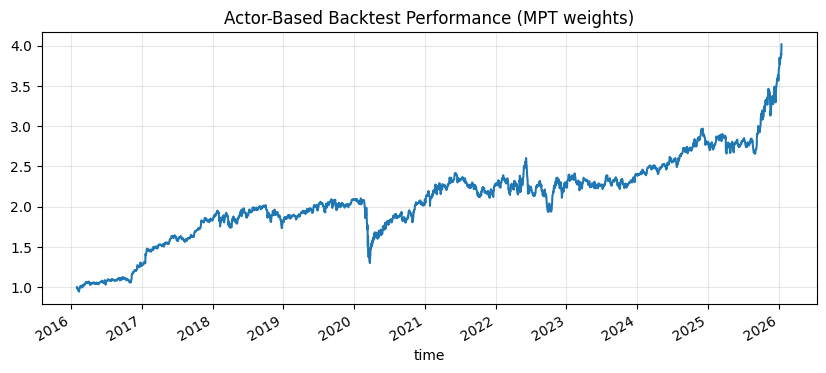

Actor Final Portfolio Value: 4015710.462799235
Actor Total Return [%]: 301.5710462799218


: 

In [ ]:
# --- Backtesting: Original Style (1N + MPT) and Actor-Based (MPT weights) ---
# Universe: held-out test assets only (asset-first split policy).

from pathlib import Path
import sys
import uuid

import numpy as np
import pandas as pd

from bokeh.io import output_notebook, show
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, StaticPool

CWD = Path.cwd()
PROJECT_ROOT = CWD.parent if CWD.name == 'notebooks' else CWD
sys.path.append(str(PROJECT_ROOT))

from src.backtester.data import load_cleaned_assets, align_close_prices
from src.backtester.engine import BacktestConfig, run_backtest
from src.backtester.report import compute_backtest_report
from src.backtester.bokeh_plots import build_interactive_portfolio_layout
from src.backtester.portfolio import equal_weight, optimize_mpt

engine_root = (PROJECT_ROOT / 'another_testing_engine' / 'trade-engine' / 'trade-engine').resolve()
if str(engine_root) not in sys.path:
    sys.path.append(str(engine_root))
from tradeengine.actors.memory import MemPortfolioActor
from tradeengine.actors.sql import SQLOrderbookActor
from tradeengine.backtest import BacktestStrategy

final_model_name = 'elasticnet'
final_pipe = enet

pred_test = final_pipe.predict(X_test)
pred_long = pd.DataFrame({'Date': df_test.index, 'Asset_ID': df_test['Asset_ID'].to_numpy(), 'y_pred': pred_test})
pred_matrix = pred_long.pivot_table(index='Date', columns='Asset_ID', values='y_pred', aggfunc='mean').sort_index()

bt_assets = sorted(pred_matrix.columns.tolist())
assets_ohlcv = load_cleaned_assets(symbols=bt_assets, cleaned_dir=str(PROJECT_ROOT / 'dataset' / 'cleaned'))
close_prices = align_close_prices(assets_ohlcv)
pred_matrix = pred_matrix.reindex(close_prices.index)
returns_matrix = close_prices.pct_change().fillna(0.0)

market_df = pd.DataFrame({
    'Open': pd.concat([df['Open'] for df in assets_ohlcv.values()], axis=1).mean(axis=1),
    'High': pd.concat([df['High'] for df in assets_ohlcv.values()], axis=1).mean(axis=1),
    'Low': pd.concat([df['Low'] for df in assets_ohlcv.values()], axis=1).mean(axis=1),
    'Close': pd.concat([df['Close'] for df in assets_ohlcv.values()], axis=1).mean(axis=1),
    'Volume': pd.concat([df['Volume'] for df in assets_ohlcv.values()], axis=1).sum(axis=1),
}).sort_index()

output_notebook()

REBALANCE_FREQ = 'W'
TOP_K = min(20, len(bt_assets))
LOOKBACK_DAYS = 126

def build_weights_from_predictions(*, pm_style: str) -> pd.DataFrame:
    # Use last *trading day* of each rebalance period (not the period label like Sunday).
    rebal_dates = set(pd.Series(pred_matrix.index, index=pred_matrix.index).resample(REBALANCE_FREQ).last().dropna().tolist())
    w_last = pd.Series(0.0, index=bt_assets)
    w_rows = []
    for dt in pred_matrix.index:
        if dt in rebal_dates:
            row = pred_matrix.loc[dt].dropna().sort_values(ascending=False)
            top = row.head(TOP_K)
            candidates = [a for a, v in top.items() if np.isfinite(v) and v > 0]
            if len(candidates) == 0:
                w_last = pd.Series(0.0, index=bt_assets)
            else:
                if pm_style == '1N':
                    w_dict = equal_weight(candidates)
                elif pm_style == 'MPT':
                    w_dict = optimize_mpt(returns_matrix, candidates, dt, lookback_days=LOOKBACK_DAYS)
                else:
                    raise ValueError(f'Unknown pm_style: {pm_style!r}')
                w_last = pd.Series(0.0, index=bt_assets)
                for a, w in w_dict.items():
                    if a in w_last.index:
                        w_last[a] = float(w)
        w_rows.append(w_last)
    return pd.DataFrame(w_rows, index=pred_matrix.index, columns=bt_assets).fillna(0.0)

weights_1n = build_weights_from_predictions(pm_style='1N')
weights_mpt = build_weights_from_predictions(pm_style='MPT')

cfg_vec = BacktestConfig(initial_equity=1_000_000.0, transaction_cost_bps=5.0, mode='vectorized')

def run_and_report(weights: pd.DataFrame, title: str):
    res = run_backtest(close_prices, weights, config=cfg_vec)
    report = compute_backtest_report(result=res, close_prices=close_prices)
    display(report.to_frame(title))
    layout = build_interactive_portfolio_layout(
        market_ohlcv=market_df,
        equity=res.equity,
        returns=res.returns,
        weights=res.weights,
        turnover=res.turnover,
        costs=res.costs,
        close_prices=close_prices,
        title=title,
    )
    show(layout)
    return res, report

_res_1n, _rpt_1n = run_and_report(weights_1n, f'Linear Model ({final_model_name}) - Original Style 1N')
_res_mpt, _rpt_mpt = run_and_report(weights_mpt, f'Linear Model ({final_model_name}) - Original Style MPT')

def weights_to_formatted_signals(w: pd.DataFrame) -> dict[str, pd.Series]:
    # Convert to trading-day timestamps (actor engine requires timestamps to exist in market data index).
    rebal_dates = pd.Series(w.index, index=w.index).resample(REBALANCE_FREQ).last().dropna().tolist()
    active: set[str] = set()
    sig: dict[str, dict[pd.Timestamp, dict]] = {a: {} for a in w.columns}
    for dt in rebal_dates:
        if dt not in w.index:
            continue
        row = w.loc[dt]
        for a in list(active):
            if float(row.get(a, 0.0)) <= 0.0:
                sig[a][dt] = {'CloseOrder': {}}
                active.remove(a)
        for a, weight in row.items():
            if float(weight) > 0.0:
                sig[a][dt] = {'TargetWeightOrder': {'size': float(weight)}}
                active.add(str(a))
    formatted: dict[str, pd.Series] = {}
    for a, d in sig.items():
        if d:
            s = pd.Series(d)
            s.index = pd.to_datetime(s.index)
            formatted[a] = s.sort_index()
        else:
            formatted[a] = pd.Series(dtype=object)
    return formatted

formatted_signals = weights_to_formatted_signals(weights_mpt)
quote_frames = {a: assets_ohlcv[a][['Open', 'High', 'Low', 'Close']] for a in bt_assets}

fund_value = 1_000_000.0
portfolio_actor = MemPortfolioActor.start(funding=fund_value)
db_engine = create_engine('sqlite://', echo=False, connect_args={'check_same_thread': False}, poolclass=StaticPool)
orderbook_actor = SQLOrderbookActor.start(portfolio_actor, db_engine, strategy_id=str(uuid.uuid4()))

print('Starting actor-based backtest (MPT weights)...')
bt_strategy = BacktestStrategy(orderbook_actor, portfolio_actor, quote_frames)
actor_result = bt_strategy.run_backtest(formatted_signals)
print('Actor backtest finished.')

perf = actor_result.porfolio_performance
fig, ax = plt.subplots(figsize=(10, 4))
perf['performance'].plot(ax=ax, title='Actor-Based Backtest Performance (MPT weights)')
ax.grid(True, alpha=0.3)
plt.show()
print('Actor Final Portfolio Value:', float(perf['value'].iloc[-1]))
print('Actor Total Return [%]:', float((perf['performance'].iloc[-1] - 1) * 100.0))
